In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

pd.set_option('display.max_columns', 500)

df = pd.read_csv('../Data/DC_Properties.csv')
df_clean = pd.read_csv('../Data/Properties_clean.csv',index_col=0)
df_clean = df_clean[df_clean.LATITUDE > 30]
df_clean.loc[:,'PPSF'] = df_clean.PRICE / df_clean.AREA

C:\Users\Sverrir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Sverrir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8,9,13,16,24,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import shapefile as shp
def shp_to_df(sf):
    # Extract labels and data
    fields = [x[0] for x in sf.fields[1:]] # Column values
    records = sf.records() # data for dataframe
    shape_data = [x.points for x in sf.shapes()]

    # Create dataframe with values
    df_geo = pd.DataFrame(columns=fields, data=records)
    df_geo['coords'] = shape_data
    
    return df_geo
# First plot: All districts with number inside

    
Shp_path = '../Data/Census_Tracts_in_2010.shp'
sf = shp.Reader(Shp_path)
df_geo = shp_to_df(sf)
df_geo = df_geo.loc[:,['TRACT','coords']]
df_geo.TRACT = df_geo.TRACT.astype(float)
df_geo.columns = ['CENSUS_TRACT','COORDS']

# Narrative requirements

- Scatterplot
- Shapefile map with colors
- Histogram


# Narrative overview

## Slide 1 (overview)
- the first slide should be something that demonstrates the abundance of the data we have available. 

> This could be a scatter plot, perhaps with the size of the appartment as the size of the circle and then some categorical variable for the colors. So brick houses would be red, and aluminium corregated sheets would be grey, etc.

> Here we'd have a discussion about the abundance of information required to make an educated desicion about buying property
> (As side by side plots) the right could be just a histogram of prices aggregated by district or some other fairly low-categorical count. 

##### Text:
Welcome to our data visualization project for the course *02806 Social data analysis and visualization*
        

The purpose is to communicate how various property characteristics play a part when a price is set. Our goal for the  user is to provide a nice visualization that can explain how different features affect the pricing of real estate. We want the user to consider and be aware of different aspects of a property when looking to buy.
  

## Slide 2 (price overview)
- The second slide contains information to give the reader and overview of the price range and distribution around the city
> On the left is a map with colored 
> (As side by side plots) If we have a map on the left

##### Text:
Let's begin our exploration by getting an overview of the price distribution in the capital. 

On the left you can see the median price of an appartment by each district and on the right you see the overall distribution of price in the city. Click on one of the cencus districts to see the price distribution compared to the rest of the city. 


## Slide 3 (Price per square foot overview)


##### Text:
We've seen that the distribution of price is highly regional, but there is more to the pricing than meets the eye. 

If a neighbourhood has houses that are twice as expensive but four times as big, then you'd be getting a lot less for your money, even if you are spending less.

Let's see if there is a diference in the price per square foot for the apartments of the city. 

We see that neighbourhoods X and Y now look a lot less expensive compared to before. 


## Slide 4 (Price per square foot, filtered by number of rooms)
We know that size isn't everything ;) it also matters how many rooms there are in the apartments. Here you can look at how the price of apartments differs by the number of rooms in each neighbourhood. 

You can pick if you want to look at the price per square foot or just the overall price. 
Select a number of rooms to see the distribution of price (or price per square foot) in each neigbourhood.


## Slide 5 (átti að vera: "optimal neighbourhood for given familiy size")
## - Nokkurnvegin replaced með 4 og 8
We've seen that that size and number of rooms can affect the price of an appartment.

As a family man, I want to know which neighbourhood has the best prices for my family, and I suspect that other families would want to know the same. 

Let's see which neighbourhood has the best price (or price per square foot) for a given size family.


## Slide 6 (Price per square foot by year filtered)
Now, we might be interested to understand other factors that come into play here than just size and number of rooms. 

Let's say I'm looking for a neighbourhood with a new house and I want to know which neighbourhood has the cheapest price per square meter for houses less than 10 years old. Let's see how this distribution varies by neighbourhood. 


## Slide 7 (Price for each residential type)
This is all good an well, but what if I'm not just interested in a house of a specific size. If I was looking specifically for a single residential home, whether it be a row home or a detatched home rather than a condo. or if I'm someone who doesn't really care what kind of house it is as long as it's got plenty of space. Then I'd have to know what kind of house I'm looking at.

Here we can a distribution of each type of home. We can see that in some tracts, there are exlusively detatched residential housing, while downtown for example, we see more of condo apartments, both horizontal and vertical.  

Here you can select the type of house you're looking for and whether you want to see the price or the price per square foot


## Slide 8 
Knowing what we know, now, let's look at a map of the best bargain choice for each neighbourhood in Washington DC

Svo sýnum við hér map þar sem í hverju neighbourhood er einhvers konar íbúðarlýsing eins og (Residential - detached - 2 bedroom) og kannski price per square meter til að sýna hversu gott price það er





In [296]:
df.USECODE.value_counts()

11     45597
12     31623
17     27511
16     24741
13     16588
24      8272
23      4497
15        79
19        31
117        8
81         4
83         2
116        1
41         1
39         1
29         1
Name: USECODE, dtype: int64

In [104]:
# BOKEH IMPORTS 
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models import NumeralTickFormatter,Label,ColumnDataSource
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs, TableColumn, DataTable

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16, inferno

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application


In [105]:
def style(p):
    # Title 
    p.title.align = 'center'
    p.title.text_font_size = '20pt'
    p.title.text_font = 'serif'

    # Axis titles
    p.xaxis.axis_label_text_font_size = '14pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_style = 'bold'

    # Tick labels
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    return p

In [729]:
df_clean.ASSESSMENT_NBHD.value_counts()

Old City 2                      15393
Old City 1                      13737
Columbia Heights                 8980
Petworth                         6140
Brookland                        6099
Deanwood                         5385
Chevy Chase                      4530
Congress Heights                 4221
Brightwood                       3845
Mt. Pleasant                     3827
Hillcrest                        3553
Capitol Hill                     3464
Georgetown                       3454
Fort Dupont Park                 3181
Central-tri 1                    3108
Kalorama                         3101
Trinidad                         2820
Cleveland Park                   2817
Southwest Waterfront             2766
Riggs Park                       2762
Randle Heights                   2652
Woodridge                        2563
Central-tri 3                    2500
American University              2396
Eckington                        2143
Forest Hills                     2096
16th Street 

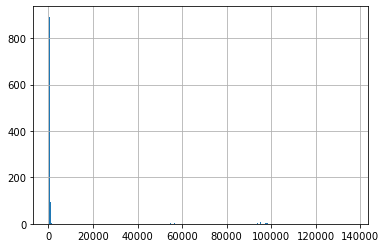

In [735]:
df_clean[df_clean.ASSESSMENT_NBHD == 'Central-tri 3'].PPSF.hist(bins=1000)


In [269]:
subset

,AC,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,AYB,BATHRM,BEDRM,CENSUS_TRACT,CNDTN,EXTWALL,EYB,FIREPLACES,GIS_LAST_MOD_DTTM,GRADE,HEAT,HF_BATHRM,INTWALL,KITCHENS,LANDAREA,LATITUDE,LONGITUDE,PRICE,QUADRANT,QUALIFIED,ROOF,ROOMS,SALEDATE,SALE_NUM,STRUCT,STYLE,USECODE,WARD,YR_RMDL,AREA,SALEYEAR,TSEYB,TSYR_RMDL,PPSF
6,Y,Old City 2,040 D Old City 2,1917.0,1.0,2.0,4201.0,Average,Common Brick,1957.0,0.0,2018-07-22 18:01:43,Above Average,Warm Cool,0.0,Hardwood,2.0,1261.0,38.914983,-77.041055,NaN,NW,U,Metal- Sms,5.0,2011-05-02 00:00:00,1.0,Row Inside,2 Story,24,Ward 2,1988.0,2520.0,2011.0,54.0,23.0,NaN
7,Y,Old City 2,040 D Old City 2,1906.0,3.0,4.0,4201.0,Average,Common Brick,1972.0,1.0,2018-07-22 18:01:43,Very Good,Hot Water Rad,1.0,Hardwood,2.0,1627.0,38.915408,-77.040129,1050000.0,NW,Q,Metal- Sms,8.0,2011-09-29 00:00:00,1.0,Row Inside,3 Story,24,Ward 2,2011.0,4802.0,2011.0,39.0,0.0,218.658892
8,Y,Old City 2,040 D Old City 2,1908.0,3.0,3.0,4201.0,Very Good,Common Brick,1967.0,1.0,2018-07-22 18:01:43,Above Average,Warm Cool,1.0,Hardwood,2.0,1424.0,38.915017,-77.039903,1430000.0,NW,Q,Built Up,7.0,2018-05-03 00:00:00,4.0,Row Inside,2 Story,24,Ward 2,2008.0,2976.0,2018.0,51.0,10.0,480.510753
9,Y,Old City 2,040 D Old City 2,1908.0,1.0,2.0,4201.0,Average,Common Brick,1950.0,0.0,2018-07-22 18:01:43,Good Quality,Hot Water Rad,1.0,Hardwood,1.0,1424.0,38.915015,-77.040081,NaN,NW,U,Built Up,6.0,2008-12-05 00:00:00,1.0,Row Inside,2 Story,11,Ward 2,1979.0,3180.0,2008.0,58.0,29.0,NaN
10,N,Old City 2,040 D Old City 2,1890.0,3.0,5.0,4201.0,Fair,Common Brick,1954.0,0.0,2018-07-22 18:01:43,Very Good,Forced Air,0.0,Hardwood,3.0,1360.0,38.914980,-77.040760,NaN,NW,U,Metal- Sms,12.0,NaN,1.0,Row Inside,3 Story,24,Ward 2,1950.0,5496.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158952,Y,Old City 2,040 B Old City 2,1938.0,1.0,1.0,4801.0,NaN,NaN,1938.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,394.0,38.911840,-77.019420,399900.0,NW,Q,NaN,3.0,2015-04-03 00:00:00,4.0,NaN,NaN,16,Ward 6,2006.0,1278.0,2015.0,77.0,9.0,312.910798
158953,Y,Old City 2,040 B Old City 2,1938.0,1.0,2.0,4801.0,NaN,NaN,1938.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,506.0,38.911840,-77.019420,416000.0,NW,Q,NaN,4.0,2013-10-04 00:00:00,1.0,NaN,NaN,16,Ward 6,2006.0,1640.0,2013.0,75.0,7.0,253.658537
158954,Y,Old City 2,040 B Old City 2,1920.0,2.0,2.0,4801.0,NaN,NaN,1920.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,467.0,38.911840,-77.019420,600000.0,NW,U,NaN,4.0,2008-09-30 00:00:00,1.0,NaN,NaN,16,Ward 6,2007.0,2334.0,2008.0,88.0,1.0,257.069409
158955,Y,Southwest Waterfront,NaN,1965.0,1.0,0.0,11000.0,NaN,NaN,1965.0,0.0,2018-07-22 18:01:38,NaN,Warm Cool,0.0,NaN,NaN,332.0,38.872953,-77.018230,215100.0,SW,Q,NaN,2.0,2015-04-14 00:00:00,3.0,NaN,NaN,17,Ward 6,NaN,894.0,2015.0,50.0,NaN,240.604027


In [270]:
subset.USECODE.value_counts()

11     39316
12     25697
17     25278
16     22403
13     15266
24      6299
23      3942
15        57
19        25
117        7
81         4
83         2
116        1
41         1
39         1
Name: USECODE, dtype: int64

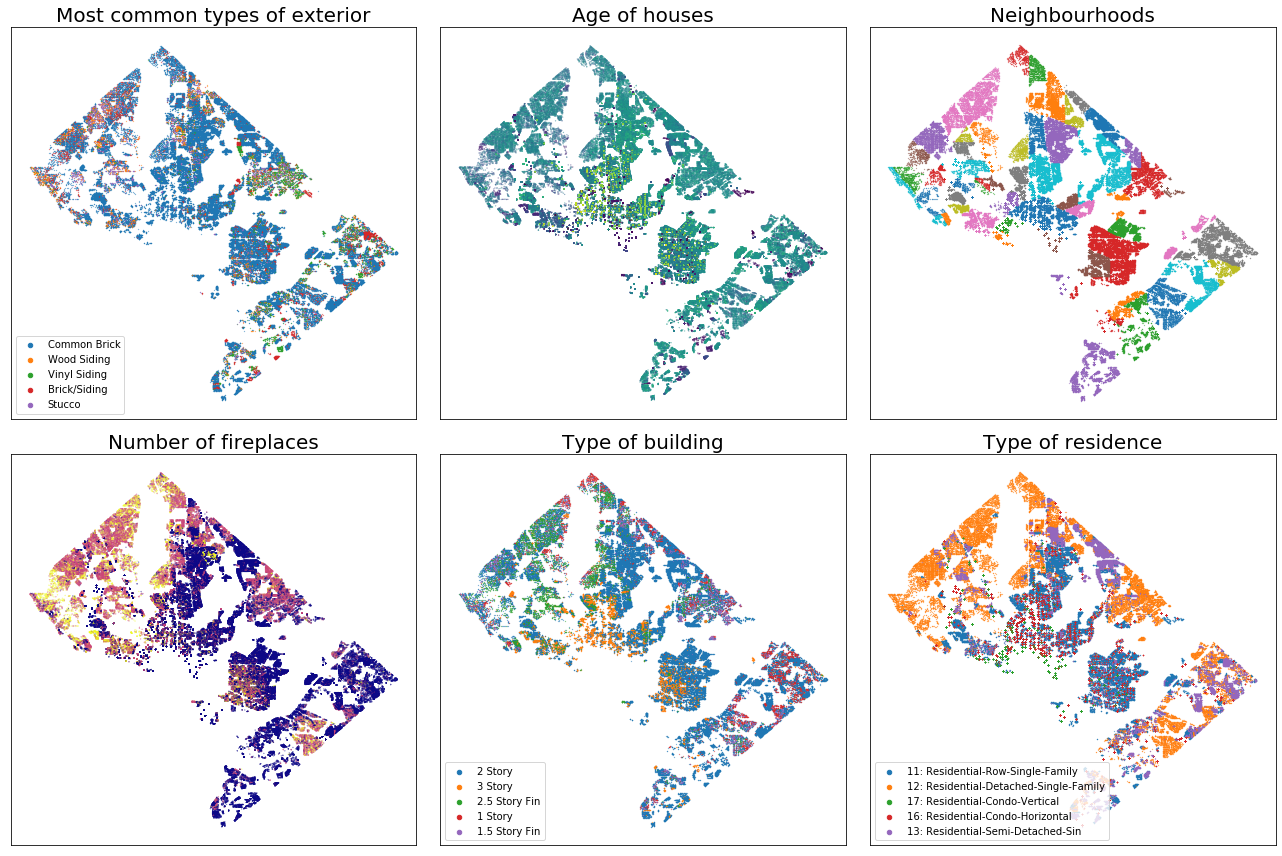

In [313]:
## Slide 1 (the first slide should be something that demonstrates the abundance of the data we have available)
###This could be a scatter plot, perhaps with the size of the appartment as the size 
### of the circle and then some categorical variable for the colors. 
### So brick houses would be red, and aluminium corregated sheets would be grey, etc.

subset = df_clean[df_clean.AREA < df_clean.AREA.quantile(0.99)].copy()
subset = subset[subset.EYB < subset.EYB.quantile(0.99)]
subset = subset[subset.EYB > subset.EYB.quantile(0.01)]
subset = subset[subset.FIREPLACES < subset.FIREPLACES.quantile(0.99)]

f,ax = plt.subplots(2,3,figsize=(18,12))
ax = np.ravel(ax)


use_code_dict = {1: 'Residential-Single Family',
                 2: 'Residential-Multi-Family',
                 3: 'Residential-Transient',
                 4: 'Commercial-Retail',
                 5: 'Commercial-Office',
                 6: 'Commercial-Specific Purpos',
                 7: 'Industrial',
                 8: 'Special Purpos',
                 11: 'Residential-Row-Single-Family',
                 12: 'Residential-Detached-Single-Family',
                 13: 'Residential-Semi-Detached-Single',
                 14: 'Residential-Garage',
                 15: 'Residential-Mixed Use use eligible',
                 16: 'Residential-Condo-Horizontal',
                 17: 'Residential-Condo-Vertical',
                 18: 'Residential-Condo-Garage dently of another unit',
                 19: 'Residential-Single-Family-Misc',
                 21: 'Residential-Apartment-Walk-Up',
                 22: 'Residential-Apartment-Elevator',
                 23: 'Residential Flats 1-5 families',
                 24: 'Residential-Conversions 1-5 families',
                 25: 'Residential-Conversion-5 Units',
                 26: 'Residential-Cooperative-Horizontal floors; may have accessory uses',
                 27: 'Residential-Cooperative-Vertical oors; may have accessory uses',
                 29: 'Residential-Multifamily, Misc',
                 31: 'Hotel-Small',
                 15: 'rooms or less'}


ax[1].scatter(subset.LONGITUDE,subset.LATITUDE,c = (subset.EYB.max() - subset.EYB),s=0.05)
ax[3].scatter(subset.LONGITUDE,subset.LATITUDE,c=subset.FIREPLACES,s=0.05,cmap='plasma')

for ext in subset.EXTWALL.value_counts().index[:5]:
    ax[0].scatter(subset[subset.EXTWALL == ext].LONGITUDE,subset[subset.EXTWALL == ext].LATITUDE,s = 0.05)
for nbh in subset.ASSESSMENT_NBHD.unique():
    ax[2].scatter(subset[subset.ASSESSMENT_NBHD == nbh].LONGITUDE,subset[subset.ASSESSMENT_NBHD == nbh].LATITUDE,s=0.05)
for style in subset.STYLE.value_counts().index[:5]:
    ax[4].scatter(subset[subset.STYLE == style].LONGITUDE,subset[subset.STYLE == style].LATITUDE,s=0.05)
for usecode in subset.USECODE.value_counts().index[:5]:
    ax[5].scatter(subset[subset.USECODE == usecode].LONGITUDE,subset[subset.USECODE == usecode].LATITUDE,s=0.05)

    
lgnd_0 = ax[0].legend(subset.EXTWALL.value_counts().index[:5],
                      markerscale=20,fontsize=10,loc='lower left')
lgnd_4 = ax[4].legend(subset.STYLE.value_counts().index[:5],
                      markerscale=20,fontsize=10,loc='lower left')
lgnd_5 = ax[5].legend([str(x) +': ' + use_code_dict[x] for x in subset.USECODE.value_counts().index[:5]],
                      markerscale=20,fontsize=10,loc='lower left')

for ax_i in ax:
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    
ax[0].set_title('Most common types of exterior',fontsize=20)
ax[1].set_title('Age of houses',fontsize=20)
ax[2].set_title('Neighbourhoods',fontsize=20)
ax[3].set_title('Number of fireplaces',fontsize=20)
ax[4].set_title('Type of building',fontsize=20)
ax[5].set_title('Type of residence',fontsize=20)

plt.tight_layout()
plt.savefig('slide 1')
plt.show()

In [278]:
use_code_dict = {11: 'Residential Row Single Family',
                 12: 'Residential Detached Single Family',
                 17: 'Residential Condo Vertical',
                 16: 'Residential Condo Horizontal',
                 13: 'Residential Semi Detached Single'}

In [358]:
subset_test

,LATITUDE,LONGITUDE,FIREPLACES
0,38.8200,-77.0056,0.0
1,38.8201,-77.0070,0.0
2,38.8202,-77.0068,0.0
3,38.8203,-77.0068,0.0
4,38.8204,-77.0067,0.0
...,...,...,...
34072,38.9947,-77.0408,1.0
34073,38.9948,-77.0414,0.0
34074,38.9948,-77.0401,1.0
34075,38.9949,-77.0403,1.0


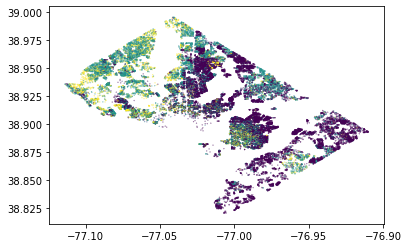

In [362]:
subset_test = subset.sample(frac=1).copy().round(4)
subset_test = subset_test.groupby(['LATITUDE','LONGITUDE'],as_index=False).agg({'FIREPLACES':'mean'}).dropna()
plt.scatter(subset_test.LONGITUDE,
              subset_test.LATITUDE,
              c=subset_test.FIREPLACES,
              s=0.05)

       LATITUDE  LONGITUDE  FIREPLACES
0       38.8200   -77.0056         0.0
1       38.8201   -77.0070         0.0
2       38.8202   -77.0068         0.0
3       38.8203   -77.0068         0.0
4       38.8204   -77.0067         0.0
...         ...        ...         ...
34072   38.9947   -77.0408         1.0
34073   38.9948   -77.0414         0.0
34074   38.9948   -77.0401         1.0
34075   38.9949   -77.0403         1.0
34076   38.9954   -77.0410         1.0

[34077 rows x 3 columns]
       LATITUDE  LONGITUDE  FIREPLACES
0       38.8200   -77.0056         0.0
1       38.8201   -77.0070         0.0
2       38.8202   -77.0068         0.0
3       38.8203   -77.0068         0.0
4       38.8204   -77.0067         0.0
...         ...        ...         ...
34072   38.9947   -77.0408         1.0
34073   38.9948   -77.0414         0.0
34074   38.9948   -77.0401         1.0
34075   38.9949   -77.0403         1.0
34076   38.9954   -77.0410         1.0

[30424 rows x 3 columns]


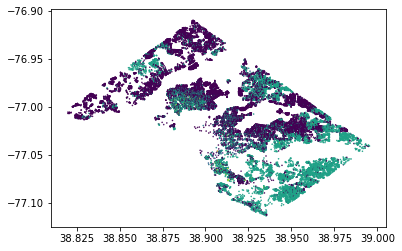

In [363]:
def scatter_categorical_map(df_new,variable,title,factor):
    # Drop all other variables than the one of interest to save computation in rounding
    df_rounded = df_new.loc[:,[variable,'LATITUDE','LONGITUDE']].dropna().copy()
    # Round the coordinates to the bin size requested
    df_rounded.loc[:,['LATITUDE','LONGITUDE']] = df_rounded.loc[:,['LATITUDE','LONGITUDE']].round(factor).copy()
    
    df_tmp  = df_rounded.copy()
#     var_by_loc = df_tmp.groupby(['LATITUDE','LONGITUDE']).agg(lambda x:x.value_counts().index[0]).loc[:,variable]
    var_by_loc = df_tmp.groupby(['LATITUDE','LONGITUDE'],as_index=False).agg({variable:'mean'}).dropna()
    print(var_by_loc)
    
    var_by_loc_99 = var_by_loc.loc[var_by_loc[variable] < np.quantile(var_by_loc[variable],0.99)]
    print(var_by_loc_99)
    plt.scatter(var_by_loc_99.loc[:,'LATITUDE'],
                var_by_loc_99.loc[:,'LONGITUDE'],
                c=var_by_loc_99[variable],
                s=0.3)
    plt.show()
    
scatter_categorical_map(subset,'FIREPLACES','FIREPLACES',4)

In [9]:
def bin_number(dataframe, n_bins):
    min_x,max_x = dataframe.loc[:,'LATITUDE'].min(),dataframe.loc[:,'LATITUDE'].max()
    min_y,max_y = dataframe.loc[:,'LONGITUDE'].min(),dataframe.loc[:,'LONGITUDE'].max()
    x_bins = np.linspace(min_x,max_x,n_bins)
    y_bins = np.linspace(min_y,max_y,n_bins)
    return x_bins,y_bins
#     plt.hist2d(df_clean.LATITUDE,df_clean.LONGITUDE,bins=[n_bins,n_bins])
#     plt.show()
    
x_bins,y_bins = bin_number(df_clean,50)

In [10]:
def aggregate_census(dataframe, 
                     constraint_variable, constraint, 
                     aggregate, factor, 
                     group_vars = ['LATITUDE','LONGITUDE']):
    '''
    dataframe: 
        Must include 'LATITUDE' & 'LONGITUDE' & 'PRICE'
    constraint_variable:
        The variable to constrain, for example 'BEDRM'
    constraint: 
        lambda function to constrain above variable with
        example: (lambda x: x == 3)
    aggregate:
        lambda function to aggregate with
        example: (lambda x: np.mean(x))
    factor: 
        number of significant digits
        example: 3
    group_vars:
        aggregation variable (if none, then LATITUDE & LONGITUDE)
        if ['CENSUS_TRACT']: then shapefiles
    '''
    # Drop all other variables than the one of interest to save computation in rounding
    df_vars = list(set([constraint_variable,'PRICE','LATITUDE','LONGITUDE'] + group_vars))
    df_sub = dataframe.loc[:,df_vars].copy()
    
    # Constrain
    df_sub = df_sub.loc[constraint(df_sub.loc[:,constraint_variable])]    
    
    # Bin by location and aggregate with function
    agg_df = df_sub.groupby(group_vars,as_index=False).agg(aggregate).loc[:,[constraint_variable,'PRICE'] + group_vars]
    
    joined_df = pd.merge(agg_df,df_geo,on='CENSUS_TRACT').dropna()
    return joined_df

In [218]:
def aggregate_census(dataframe, constraint_variable, constraint, aggregate, output = 'PRICE'):
    df_sub = dataframe.loc[:,[constraint_variable,output,'CENSUS_TRACT']].copy()
    df_sub = df_sub.loc[constraint(df_sub.loc[:,constraint_variable])]
    agg_df = df_sub.groupby('CENSUS_TRACT',as_index=False).agg(aggregate)
    return pd.merge(agg_df,df_geo,on='CENSUS_TRACT')

In [219]:
from missingno import matrix
# matrix()

In [239]:
# Price map for specific number of bedrooms/rooms
# Mean, median, most common, min/max?
def price_map_with_constraints(dataframe, 
                               constraint_variable, constraint, 
                               aggregate, factor, 
                               group_vars = ['LATITUDE','LONGITUDE'],output = 'PRICE',
                               only_best = False):
    
    
    joined_df = aggregate_census(dataframe, constraint_variable, constraint, aggregate, output).dropna()
    
    price_low = 0
    price_high = np.percentile(joined_df.loc[:,output],95)
    
    c_values = joined_df.loc[:,output]/price_high
    
    
    f,ax = plt.subplots(1,2, figsize=(12,6))
    
    ax[1].hist(joined_df.loc[joined_df.loc[:,output] < price_high,output],bins=100)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    # Get corresponding colors from map
    color_sq = [plt.cm.get_cmap('plasma')(x) for x in c_values]

    
    for n,(color,district) in enumerate(zip(color_sq,joined_df.iterrows())):
        # Plot outlines
        x_lon = np.array(district[1].COORDS)[:,0]
        y_lat = np.array(district[1].COORDS)[:,1]

        c_val = 'black'
        if only_best:
            if c_values.iloc[n] == np.min(c_values):
                ax[0].fill(x_lon,y_lat, color=color)
                ax[0].plot(x_lon,y_lat, color='black',lw=0.5)
            else:
                ax[0].plot(x_lon,y_lat, color='black',lw=0.5)
        else:
            ax[0].fill(x_lon,y_lat, color=color)
            ax[0].plot(x_lon,y_lat, color='black',lw=0.5)
            ax[0].set_title(output)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=price_high))
    cbar = plt.colorbar(sm, ticks=np.linspace(0,price_high,5), orientation="horizontal",ax=ax[0],)
    plt.tight_layout()
    plt.show()
    

    return joined_df

In [240]:
# # Constrained variable
# c_var = 'BEDRM'

# # Constraint function
# constr_1 = (lambda x: x == 2)
# constr_2 = (lambda x: x == 3)
# constr_3 = (lambda x: x == 5)
# constr_true = (lambda x: x > 0)

# # Mean, median, most_common
# agg_1 = (lambda x: np.mean(x))
# agg_2 = (lambda x: np.median(x))
# agg_3 = (lambda x: x.value_counts().index[0])

# aggregate_census(df_clean, c_var, constr_3, agg_1)

In [241]:
# Constrained variable 
c_var = 'BEDRM'

# Constraint function

constr_1 = (lambda x: x == 2)
constr_2 = (lambda x: x == 3)
constr_3 = (lambda x: x == 5)
constr_true = (lambda x: x > 0)

# Mean, median, most_common
agg_1 = (lambda x: np.mean(x))
agg_2 = (lambda x: np.median(x))
agg_3 = (lambda x: x.value_counts().index[0])

# groupby_vars 
grp_vars = ['CENSUS_TRACT']

# Output 
output_1 = 'PRICE'
output_2 = 'PPSF'

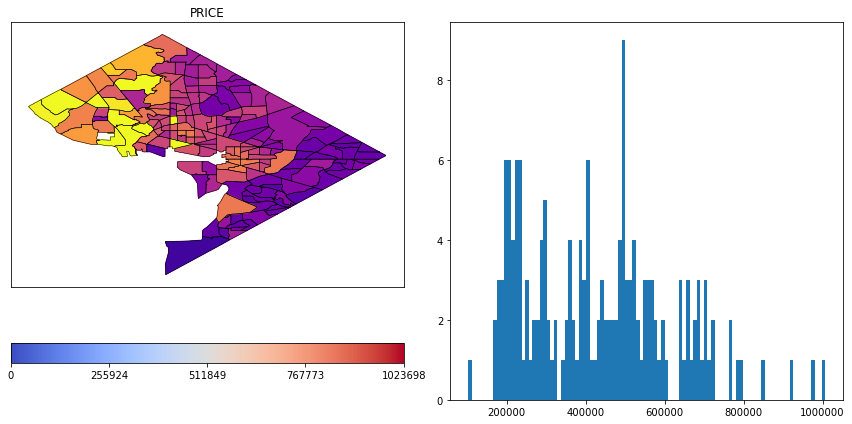

In [294]:
# Slide 2
var_by_loc = price_map_with_constraints(df_clean, c_var, constr_true, agg_1, 3, grp_vars,output_1)

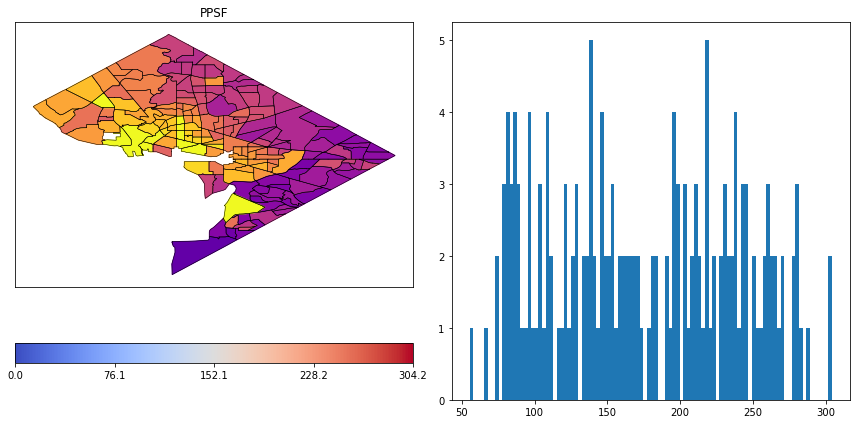

In [243]:
# Slide 3
grp_vars = ['CENSUS_TRACT']
agg = (lambda x: np.mean(x))
constr = (lambda x: x != 0)
c_var = 'BEDRM'
output = 'PPSF'
var_by_loc = price_map_with_constraints(df_clean, c_var, constr, agg, None, grp_vars,output)

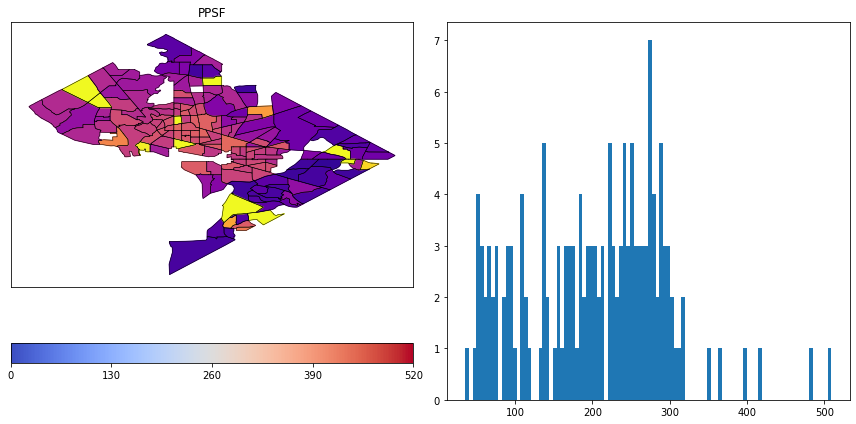

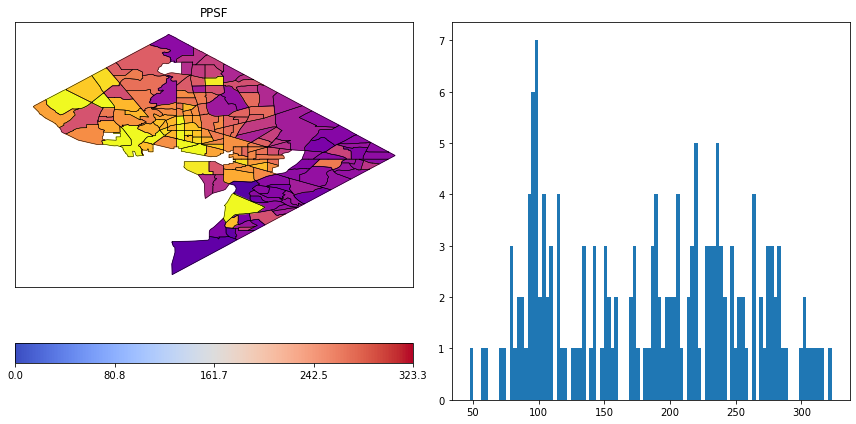

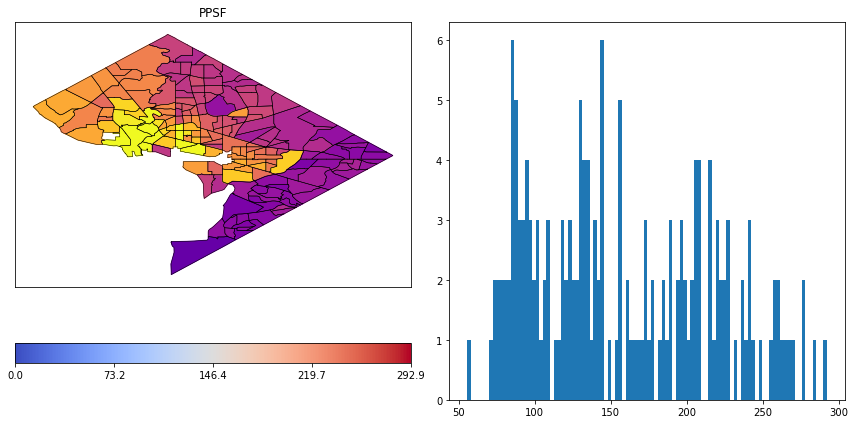

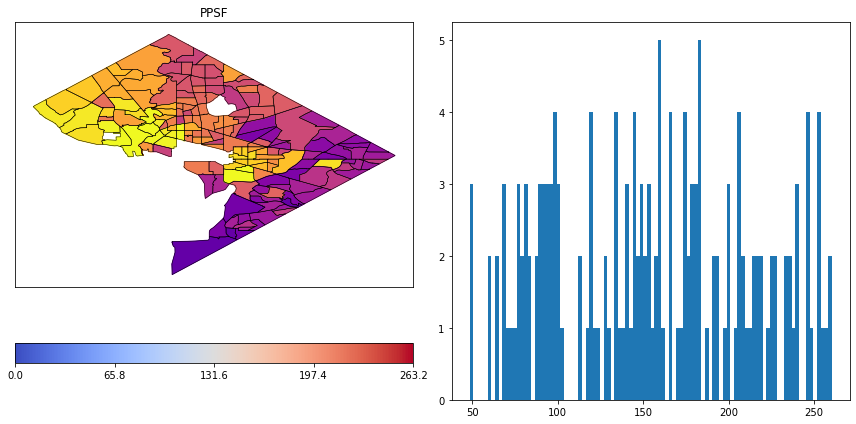

In [249]:
# slide 4
grp_vars = ['CENSUS_TRACT']
agg = (lambda x: np.mean(x))
constr1 = (lambda x: x == 1)
constr2 = (lambda x: x == 2)
constr3 = (lambda x: x == 3)
constr4 = (lambda x: x == 4)
output = 'PPSF'
var_by_loc = price_map_with_constraints(df_clean, c_var, constr1, agg, None, grp_vars,output,only_best = False)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr2, agg, None, grp_vars,output,only_best = False)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr3, agg, None, grp_vars,output,only_best = False)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr4, agg, None, grp_vars,output,only_best = False)

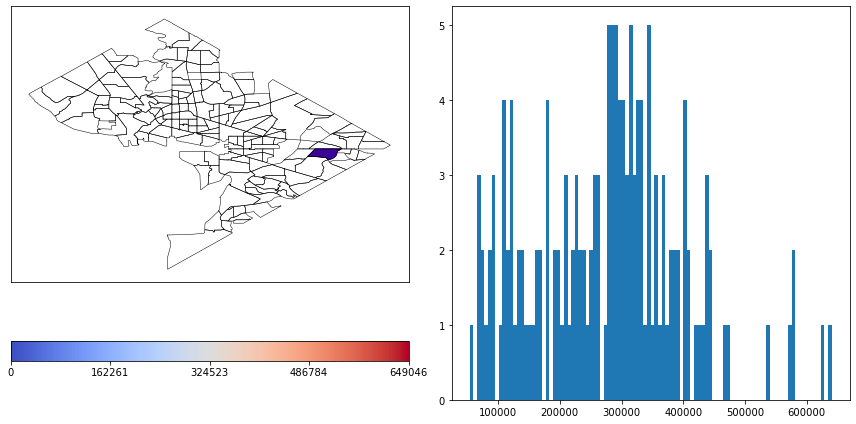

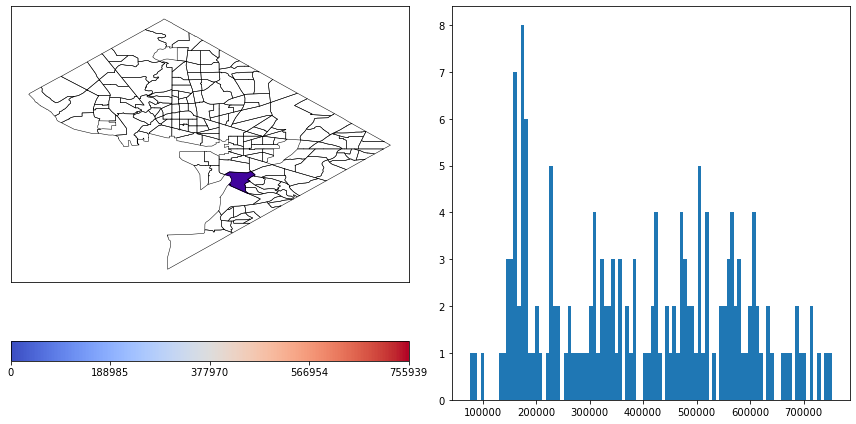

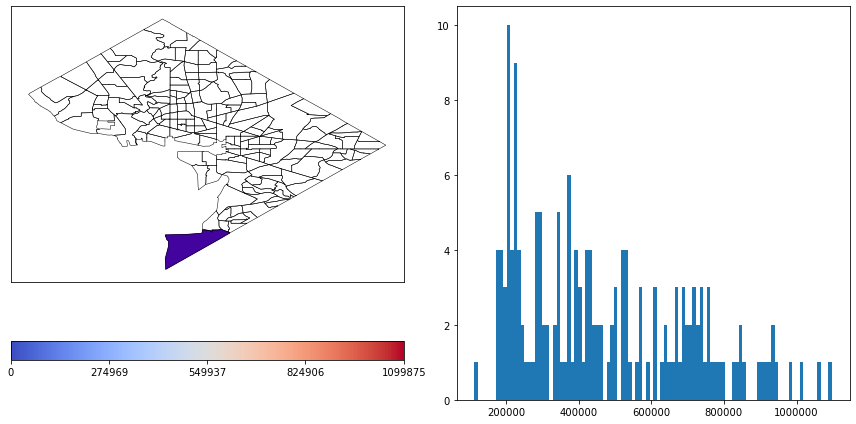

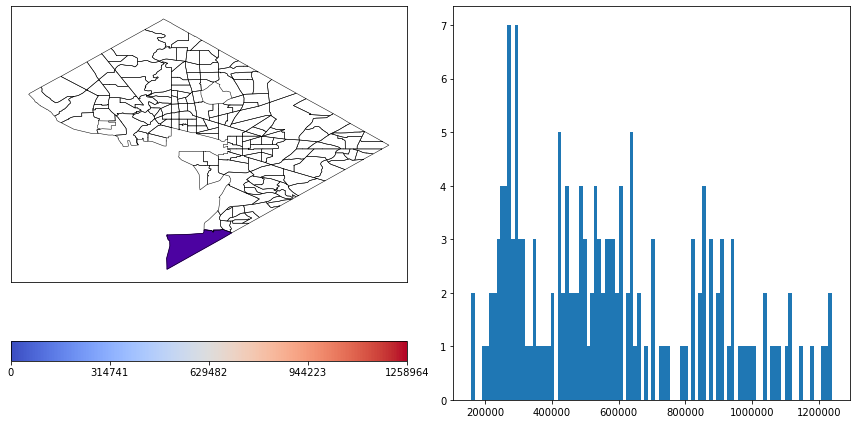

In [248]:
# slide 4
grp_vars = ['CENSUS_TRACT']
agg = (lambda x: np.mean(x))
constr1 = (lambda x: x == 1)
constr2 = (lambda x: x == 2)
constr3 = (lambda x: x == 3)
constr4 = (lambda x: x == 4)
output = 'PPSF'
var_by_loc = price_map_with_constraints(df_clean, c_var, constr1, agg, None, grp_vars,output,only_best = True)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr2, agg, None, grp_vars,output,only_best = True)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr3, agg, None, grp_vars,output,only_best = True)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr4, agg, None, grp_vars,output,only_best = True)

In [251]:
df_clean.TSEYB

0         31.0
2         32.0
3         22.0
4          NaN
5         38.0
          ... 
158952    77.0
158953    75.0
158954    88.0
158955    50.0
158956    37.0
Name: TSEYB, Length: 146995, dtype: float64

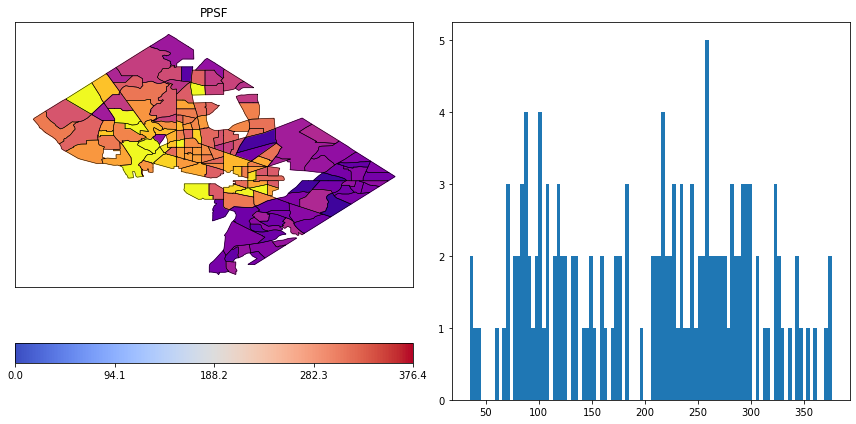

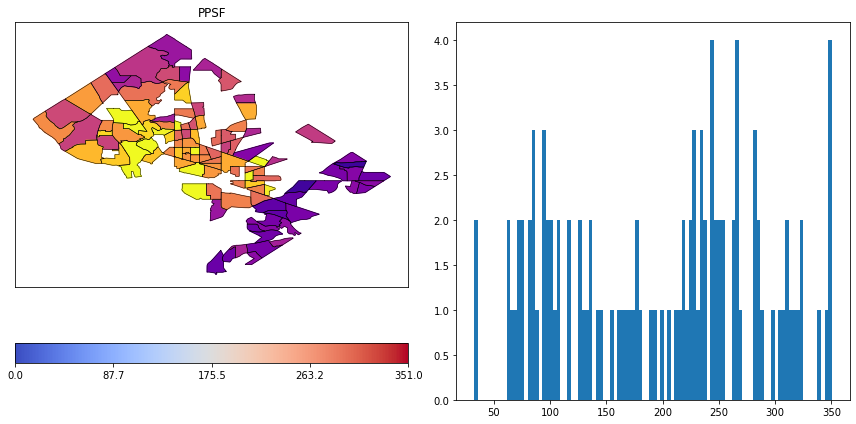

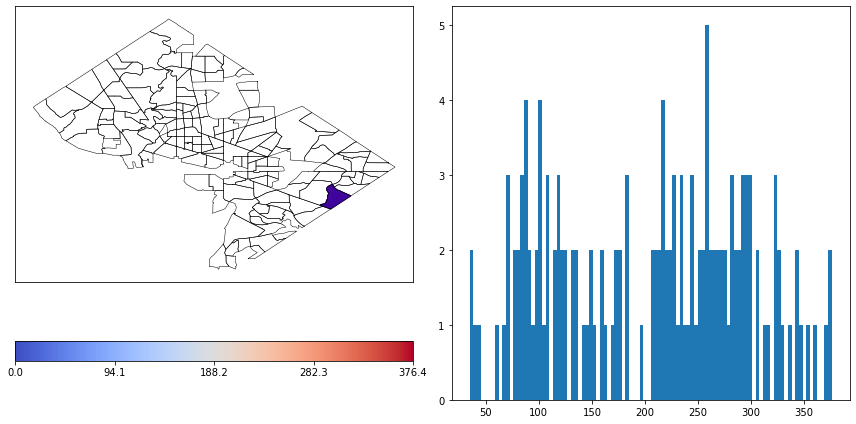

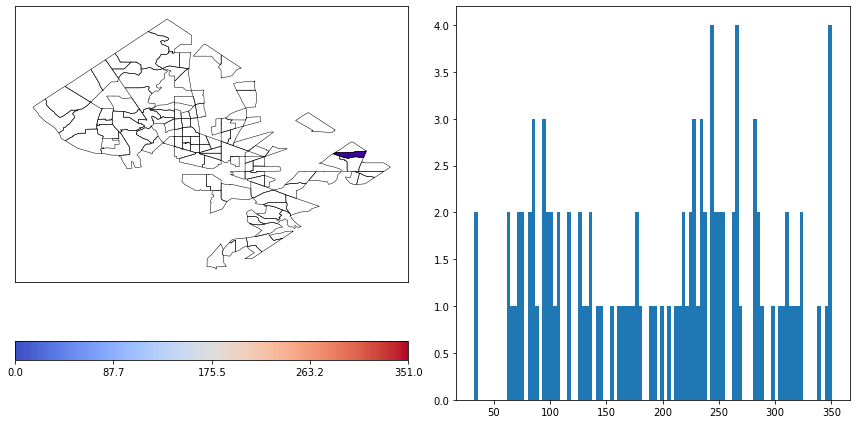

In [257]:
# slide 4
grp_vars = ['CENSUS_TRACT']
agg = (lambda x: np.mean(x))
c_var = 'TSEYB' #time since estimated year built
constr1 = (lambda x: (x < 10) & (x > 5))
constr1 = (lambda x: x < 5)
output = 'PPSF'
var_by_loc = price_map_with_constraints(df_clean, c_var, constr1, agg, None, grp_vars,output,only_best = False)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr2, agg, None, grp_vars,output,only_best = False)

var_by_loc = price_map_with_constraints(df_clean, c_var, constr1, agg, None, grp_vars,output,only_best = True)
var_by_loc = price_map_with_constraints(df_clean, c_var, constr2, agg, None, grp_vars,output,only_best = True)

In [374]:
df_clean

,AC,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,AYB,BATHRM,BEDRM,CENSUS_TRACT,CNDTN,EXTWALL,EYB,FIREPLACES,GIS_LAST_MOD_DTTM,GRADE,HEAT,HF_BATHRM,INTWALL,KITCHENS,LANDAREA,LATITUDE,LONGITUDE,PRICE,QUADRANT,QUALIFIED,ROOF,ROOMS,SALEDATE,SALE_NUM,STRUCT,STYLE,USECODE,WARD,YR_RMDL,AREA,SALEYEAR,TSEYB,TSYR_RMDL,PPSF
0,Y,Old City 2,040 D Old City 2,1910.0,4.0,4.0,4201.0,Good,Common Brick,1972.0,5.0,2018-07-22 18:01:43,Very Good,Warm Cool,0.0,Hardwood,2.0,1680.0,38.914680,-77.040832,1095000.0,NW,Q,Metal- Sms,8.0,2003-11-25 00:00:00,1.0,Row Inside,3 Story,24,Ward 2,1988.0,5044.0,2003.0,31.0,15.0,217.089611
2,Y,Old City 2,040 D Old City 2,1910.0,3.0,5.0,4201.0,Very Good,Common Brick,1984.0,4.0,2018-07-22 18:01:43,Very Good,Hot Water Rad,1.0,Hardwood,2.0,1680.0,38.914684,-77.040678,2100000.0,NW,Q,Built Up,9.0,2016-06-21 00:00:00,3.0,Row Inside,3 Story,24,Ward 2,2009.0,5044.0,2016.0,32.0,7.0,416.336241
3,Y,Old City 2,040 D Old City 2,1900.0,3.0,5.0,4201.0,Good,Common Brick,1984.0,3.0,2018-07-22 18:01:43,Very Good,Hot Water Rad,1.0,Hardwood,2.0,1680.0,38.914683,-77.040629,1602000.0,NW,Q,Built Up,8.0,2006-07-12 00:00:00,1.0,Row Inside,3 Story,24,Ward 2,2003.0,4968.0,2006.0,22.0,3.0,322.463768
4,Y,Old City 2,040 D Old City 2,1913.0,2.0,3.0,4201.0,Good,Common Brick,1985.0,0.0,2018-07-22 18:01:43,Very Good,Warm Cool,1.0,Hardwood,1.0,2032.0,38.914383,-77.039361,NaN,NW,U,Neopren,11.0,NaN,1.0,Semi-Detached,3 Story,13,Ward 2,2012.0,10510.0,NaN,NaN,NaN,NaN
5,Y,Old City 2,040 D Old City 2,1913.0,3.0,5.0,4201.0,Good,Common Brick,1972.0,4.0,2018-07-22 18:01:43,Very Good,Hot Water Rad,2.0,Hardwood,1.0,2196.0,38.914331,-77.039715,1950000.0,NW,Q,Built Up,10.0,2010-02-26 00:00:00,1.0,Row Inside,4 Story,11,Ward 2,NaN,10688.0,2010.0,38.0,NaN,182.447605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158952,Y,Old City 2,040 B Old City 2,1938.0,1.0,1.0,4801.0,NaN,NaN,1938.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,394.0,38.911840,-77.019420,399900.0,NW,Q,NaN,3.0,2015-04-03 00:00:00,4.0,NaN,NaN,16,Ward 6,2006.0,1278.0,2015.0,77.0,9.0,312.910798
158953,Y,Old City 2,040 B Old City 2,1938.0,1.0,2.0,4801.0,NaN,NaN,1938.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,506.0,38.911840,-77.019420,416000.0,NW,Q,NaN,4.0,2013-10-04 00:00:00,1.0,NaN,NaN,16,Ward 6,2006.0,1640.0,2013.0,75.0,7.0,253.658537
158954,Y,Old City 2,040 B Old City 2,1920.0,2.0,2.0,4801.0,NaN,NaN,1920.0,0.0,2018-07-22 18:01:38,NaN,Forced Air,0.0,NaN,NaN,467.0,38.911840,-77.019420,600000.0,NW,U,NaN,4.0,2008-09-30 00:00:00,1.0,NaN,NaN,16,Ward 6,2007.0,2334.0,2008.0,88.0,1.0,257.069409
158955,Y,Southwest Waterfront,NaN,1965.0,1.0,0.0,11000.0,NaN,NaN,1965.0,0.0,2018-07-22 18:01:38,NaN,Warm Cool,0.0,NaN,NaN,332.0,38.872953,-77.018230,215100.0,SW,Q,NaN,2.0,2015-04-14 00:00:00,3.0,NaN,NaN,17,Ward 6,NaN,894.0,2015.0,50.0,NaN,240.604027


In [384]:
df_CT_BD_agg

,CENSUS_TRACT,BEDRM,USECODE,PPSF,AC
0,100.0,0.0,16,275.763112,13
1,100.0,0.0,17,218.545528,58
2,100.0,0.0,19,NaN,2
3,100.0,0.0,23,NaN,1
4,100.0,0.0,117,285.171103,1
...,...,...,...,...,...
4241,11100.0,6.0,24,25.897151,2
4242,11100.0,7.0,12,NaN,1
4243,11100.0,7.0,24,48.947069,2
4244,11100.0,8.0,12,113.066645,3


In [1]:
df_CT_BD_agg = df_clean.groupby(['CENSUS_TRACT','BEDRM','USECODE'],as_index=False).agg({'PPSF':'mean',
                                                                                       'AC':'count'}).copy()

CT_min = pd.DataFrame(index = df_CT_BD_agg.CENSUS_TRACT.unique())
CT_min.loc[:,'PPSF'] = None
CT_min.loc[:,'USECODE'] = None
CT_min.loc[:,'BEDRM'] = None

for CT in df_CT_BD_agg.CENSUS_TRACT.unique():
    CT_subset = df_CT_BD_agg.loc[df_CT_BD_agg.CENSUS_TRACT == CT]
    CT_subset = CT_subset[CT_subset.AC >= 20]
    if len(CT_subset) > 0:
        idx_min = CT_subset.PPSF.idxmin()
        CT_min.loc[CT,'USECODE'] = CT_subset.loc[idx_min,'USECODE']
        CT_min.loc[CT,'BEDRM'] = CT_subset.loc[idx_min,'BEDRM']
        CT_min.loc[CT,'PPSF'] = CT_subset.loc[idx_min,'PPSF']

CT_min.loc[:,'CENSUS_TRACT'] = CT_min.index
CT_min.index = np.arange(0,len(CT_min))
joined_df = pd.merge(CT_min,df_geo,on='CENSUS_TRACT')
joined_df = joined_df.dropna()

NameError: name 'df_clean' is not defined

In [536]:
print(np.unique([use_code_dict[y] for x,y in zip(joined_df.BEDRM,joined_df.USECODE)]))
print(np.unique([str(x)+' bedrooms' for x,y in zip(joined_df.BEDRM,joined_df.USECODE)]))


['Residential Flats 1-5 families' 'Residential-Condo-Horizontal'
 'Residential-Condo-Vertical' 'Residential-Conversions 1-5 families'
 'Residential-Detached-Single-Family' 'Residential-Row-Single-Family'
 'Residential-Semi-Detached-Sin']
['0.0 bedrooms' '1.0 bedrooms' '2.0 bedrooms' '3.0 bedrooms'
 '4.0 bedrooms' '5.0 bedrooms' '6.0 bedrooms' '8.0 bedrooms']


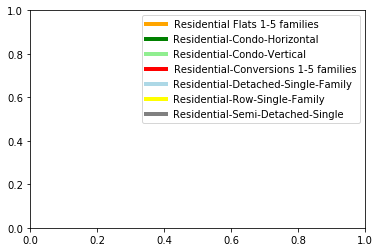

In [636]:
np.

array([ 1, -1])

In [722]:
def centroid(vertexes):
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    x_weights = np.abs(np.diff(_x_list))
    y_weights = np.abs(np.diff(_y_list))
    
    _x_list = np.mean(np.array([_x_list[1:],_x_list[:-1]]),axis=0)
    _y_list = np.mean(np.array([_y_list[1:],_y_list[:-1]]),axis=0)
    _len = len(vertexes)
    _x = np.sum(_x_list*x_weights/np.sum(x_weights))
    _y = np.sum(_y_list*y_weights/np.sum(y_weights))
    return(_x, _y)

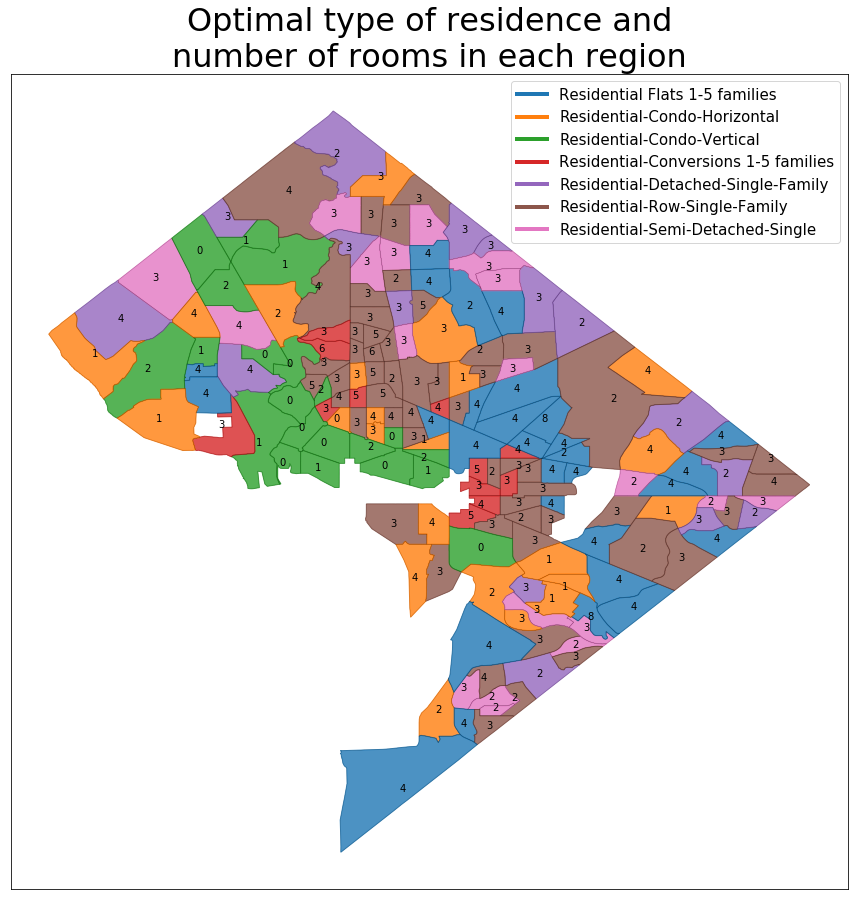

In [736]:
cyc = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
       '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
       '#bcbd22', '#17becf']

color_dict_usecode = {'Residential Flats 1-5 families':cyc[0],
                      'Residential-Condo-Horizontal':cyc[1],
                      'Residential-Condo-Vertical':cyc[2],
                      'Residential-Conversions 1-5 families':cyc[3],
                      'Residential-Detached-Single-Family':cyc[4],
                      'Residential-Row-Single-Family':cyc[5],
                      'Residential-Semi-Detached-Single':cyc[6]}

plt.figure(figsize=(15,15))
for n,(index,val) in enumerate(joined_df.iterrows()):
    x,y = np.array(val.COORDS).T
    plt.fill(x,y,c=color_dict_usecode[use_code_dict[val.USECODE]],alpha=0.8)
    plt.plot(x,y,color='black',linewidth=0.1)    
    
    x_t,y_t = centroid(np.array([x,y]).T)
#     print(x_t,y_t)
#     plt.text(x_t,y_t,val.BEDRM.astype(int))
    plt.text(x_t-0.0015,y_t-0.0005,val.BEDRM.astype(int))
    
#     plt.text(np.min(x)+(np.max(x)-np.min(x))/2-0.002,
#              np.min(y)+(np.max(y)-np.min(y))/2-0.001,val.BEDRM.astype(int))
    

plt.title('Optimal type of residence and\nnumber of rooms in each region',fontsize=32)
plt.xticks([])
plt.yticks([])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cyc[0], lw=4),
                Line2D([0], [0], color=cyc[1], lw=4),
                Line2D([0], [0], color=cyc[2], lw=4),
                Line2D([0], [0], color=cyc[3], lw=4),
                Line2D([0], [0], color=cyc[4], lw=4),
                Line2D([0], [0], color=cyc[5], lw=4),
                Line2D([0], [0], color=cyc[6], lw=4)]

plt.legend(custom_lines, color_dict_usecode.keys(),fontsize=15)
plt.savefig('final')